<h1><span style="color:red"> Перезапуск ноутбука не сработает по причине затёртых данных подключения к Базе Данных.</span></h1>

## Задачи.
1. Построить рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы. Для этого потребуется подготовить и проанализировать имеющиеся данные. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями.
2. Проанализировать результаты А/Б-теста, через месяц проведённого после внедрения фичи, сделать вывод.

Содержание:
- [Задача 1.](#Task1_start)
- [Выводы по задаче 1.](#Task1_end)
- [Задача 2.](#Task2_start)
- [Выводы по задаче 2.](#Task2_end)

<a id='Task1_start'></a>
## Задача 1. Строим рекомендательную систему.

In [1]:
# Импортируем необходимые библиотеки.
import pandas as pd
import psycopg2
import psycopg2.extras
import itertools
import random
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Получим данные по покупкам пользователей.
def getCarts():
    query = '''
        WITH
        -- Объединим две таблички с успешными покупками курсов.
        all_successful_carts as
            (
            SELECT
                *
            FROM
                final.carts as c
                    INNER JOIN final.cart_items as i
                        on c.id = i.cart_id
            WHERE
                c.state='successful'
                AND i.resource_type='Course'
            ),
        /**
        Из таблицы выше найдём тех пользователей,
        которые приобрели как минимум два РАЗНЫХ курса.
        **/
        users as
            (
            SELECT
                t.user_id
            FROM
                all_successful_carts as t
            GROUP BY
                1
            HAVING
                COUNT(DISTINCT t.resource_id)>1
            )
        /**
        Итоговый срез данных: данные по всем продажам курсов в разрезе пользователей, которые
        купили минимум два разных курса.
        **/
        SELECT
            t.cart_id,
            t.user_id,
            t.resource_id
        FROM
            all_successful_carts as t
                INNER JOIN users as u
                    on t.user_id=u.user_id
        '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

df = pd.DataFrame(getCarts())

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34172 entries, 0 to 34171
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cart_id      34172 non-null  int64
 1   user_id      34172 non-null  int64
 2   resource_id  34172 non-null  int64
dtypes: int64(3)
memory usage: 801.0 KB


Пропусков нет.

In [4]:
df.head()

,cart_id,user_id,resource_id
0,230789,1010882,490
1,230722,1010802,514
2,283372,1120298,514
3,258959,750528,552
4,230985,191574,523


In [5]:
df['user_id'].nunique()

12656

Уникальных пользователей 12656. Данные не имеют пропусков.

In [6]:
# Составим set из купленных курсов по каждому пользователю без разделения непосредственно на покупки.
# set - используется для убирания дубликатов курсов, т.е. когда пользователь дважды покупал курс.
df_courses_grp = df.groupby(['user_id'])['resource_id'].apply(set).to_frame()
courses = df_courses_grp['resource_id'].apply(lambda x: list(x))

# Обязательно отсортируем по возрастанию воизбежание
# появления разных вариаций списков с одними и теми же значениями.
courses.apply(lambda x: x.sort())
courses.head()

user_id
51            [516, 1099]
6117     [356, 357, 1125]
10275         [553, 1147]
10457         [361, 1138]
17166          [356, 357]
Name: resource_id, dtype: object

In [7]:
# Применим метод combinations(x, length) из библиотеки itertools смысл которого 
# в переборе всех возможных комбинаций значений длиной length списка без повторений.
pairs_of_courses_by_user = courses.apply(lambda x: list(itertools.combinations(x, 2)))
pairs_of_courses_by_user.head()

user_id
51                                [(516, 1099)]
6117     [(356, 357), (356, 1125), (357, 1125)]
10275                             [(553, 1147)]
10457                             [(361, 1138)]
17166                              [(356, 357)]
Name: resource_id, dtype: object

In [8]:
# В итоге получили Series по каждому user_id с списком всех возможных пар купленных курсов.
# Сделаем из него DataFrame в строках которого будут перечислены 
# все возможные пары курсов по каждому user_id.
df_pairs_of_courses_by_user = pd.DataFrame(pairs_of_courses_by_user.to_list())
df_pairs_of_courses_by_user.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
0,"(516, 1099)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"(356, 357)","(356, 1125)","(357, 1125)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"(553, 1147)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"(361, 1138)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"(356, 357)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
# Мы видим 171 столбeц - это нам говорит о том, что кто-то из пользователей купил 19 уникальных курсов.
# Откуда это? Из формулы: допустим было куплено N курсов, значит кол-во возможных пар = N*(N-1)/2
# Проверим это:
tmpDf = courses.to_frame()
tmpDf['cnt_courses'] = tmpDf['resource_id'].apply(lambda x: len(x))
tmpDf.sort_values('cnt_courses', ascending=False).head()

,resource_id,cnt_courses
user_id,,
694146,"[489, 490, 515, 523, 552, 564, 566, 670, 764, ...",19
953401,"[490, 502, 514, 515, 518, 519, 523, 551, 552, ...",18
1050532,"[363, 366, 489, 502, 511, 523, 551, 552, 562, ...",18
992470,"[489, 502, 514, 515, 517, 518, 519, 523, 551, ...",17
722252,"[357, 366, 489, 490, 502, 514, 515, 523, 551, ...",17


У пользователя с id 694146 было куплено 19 разных курсов.

In [10]:
# Преобразуем DataFrame в Series в котором будут только пары курсов по каждому пользователю
# в одну колонку.
all_pairs_of_courses = pd.Series(dtype='object')
for i in df_pairs_of_courses_by_user:
    all_pairs_of_courses = pd.concat([all_pairs_of_courses,df_pairs_of_courses_by_user[i].dropna()])
all_pairs_of_courses.reset_index(drop=True)

0         (516, 1099)
1          (356, 357)
2         (553, 1147)
3         (361, 1138)
4          (356, 357)
             ...     
40012    (1103, 1116)
40013    (1103, 1156)
40014    (1115, 1116)
40015    (1115, 1156)
40016    (1116, 1156)
Length: 40017, dtype: object

In [11]:
# Посчитаем наиболее частовстречающиеся пары курсов.
df_pairs_count = all_pairs_of_courses.value_counts()
print('Всего уникальных пар курсов:', len(df_pairs_count))
print('Самая часто встречающаяся пара:', df_pairs_count.index[0])

Всего уникальных пар курсов: 3989
Самая часто встречающаяся пара: (551, 566)


In [12]:
df_pairs_count = df_pairs_count.reset_index()
df_pairs_count.columns = ['pair_of_courses', 'amount']
df_pairs_count.head()

,pair_of_courses,amount
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290


<AxesSubplot:>

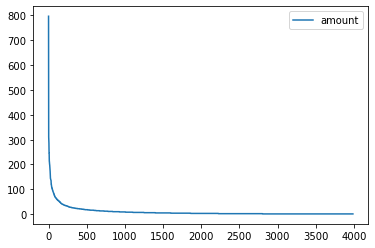

In [13]:
df_pairs_count.plot()

In [14]:
print('Медианное и среднее кол-во встречающихся пар курсов (соответственно):', df_pairs_count['amount'].median(), 'и', round(df_pairs_count['amount'].mean()))
print('Всего возможных пар:', len(df_pairs_count))
print('Кол-во пар курсов больше или равных медаине и среднему:',\
      len(df_pairs_count[df_pairs_count['amount'] >= df_pairs_count['amount'].median()]),\
      'и',\
      len(df_pairs_count[df_pairs_count['amount'] >= df_pairs_count['amount'].mean()]))

Медианное и среднее кол-во встречающихся пар курсов (соответственно): 3.0 и 10
Всего возможных пар: 3989
Кол-во пар курсов больше или равных медаине и среднему: 2226 и 841


График кол-ва разных купленных пар курсов указывает нам на то, что большая часть пар курсов повторяется в покупках при менее 50 повторах. Учитывая это, появляется вопрос: насколько "популярна" должна быть пара курсов, чтобы мы могли эту пару использовать в качестве "основы" для рекомендации? Как видим выше, если взять в качестве "отправной точки" среднее, то большинство (80%) всех пар отпадает, поэтому я решил остановится на медиане при которой остается больше половины всех пар.

Здесь уместна фраза: "один раз - случайность, два раза - совпадение, три раза - закономерность". :-)

Но не стоит забывать, что изначально мы составили список только по тем курсам, которые покупались пользователями совместно с другими. Учитывая это и что часть пар мы отбросим, то скорее всего будут курсы, которые не будут иметь рекомендации, а рекомендательная система априори должна работать для каждого продаваемого курса.

Поэтому загрузим все имеющиеся курсы (т.к. у нас имеется доступ к очень ограниченному кол-ву данных и список всех имеющихся курсов мы получить не можем, то допустим что каждый курс был продан хотя бы один раз). Далее для каждого курса мы подберём два в качестве рекомендаций исходя из следующих условий:
1. Ищем рекомендуемый курс в "популярных" парах. Если не нашли или нашли только один, то "см. п. 2". Если у исходного курса имеется несколько пар с одинаковой "популярностью", то будем брать из той пары, в которой находится наиболее продаваемый курс.
2. Рекомендуем наиболее продаваемый курс рандомно из лучшей 20-ки.

In [15]:
# Отберём часть пар с кол-вом повтором больше или равным медиане.
# Колонку с списком курсов разобьем на две, затем её удалим.
df_pairs = df_pairs_count[df_pairs_count['amount'] >= df_pairs_count['amount'].median()].copy()
df_pairs[['c1', 'c2']] = pd.DataFrame(df_pairs['pair_of_courses'].to_list())
df_pairs = df_pairs.drop(columns='pair_of_courses')
print('Кол-во строк в df_pairs:', len(df_pairs))
df_pairs.head()

Кол-во строк в df_pairs: 2226


,amount,c1,c2
0,797,551,566
1,417,515,551
2,311,489,551
3,304,523,551
4,290,566,794


In [16]:
# По первой строке видно: курсу 551 стоит рекомендовать курс 566, т.к. в такой паре они попадаются 797 раз.
# Только и в обратную сторону это тоже справедливо: курсу 566 стоит рекомендовать курс 551 по той же причине.
# Чтобы в дальнейшем искать рекомендуемый курс быстрее, мы данный датафрейм объединим с самим собой, добавив снизу и
# переставив колонки c1 и c2 местами. Таким образом достаточно будет один раз произвести отбор по одной из колонок
# чтобы найти нужную пару.
tmpDf = df_pairs.copy()
tmpDf.columns = ['amount','c2','c1']
df_pairs = df_pairs.append(tmpDf[['amount','c1','c2']], ignore_index=True).sort_values('amount', ascending=False, ignore_index=True)
print('Кол-во строк в df_pairs:', len(df_pairs))
df_pairs.head()

Кол-во строк в df_pairs: 4452


,amount,c1,c2
0,797,551,566
1,797,566,551
2,417,551,515
3,417,515,551
4,311,551,489


In [17]:
# Загрузим все успешные покупки пользователей.
def getCarts():
    query = '''
        SELECT
            c.user_id,
            i.cart_id,
            i.resource_id
        FROM
            final.carts as c
                INNER JOIN final.cart_items as i
                    on c.id = i.cart_id
        WHERE
            c.state='successful'
            AND i.resource_type='Course'
        '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

all_successful_carts = pd.DataFrame(getCarts())
all_successful_carts.head()

,user_id,cart_id,resource_id
0,1010882,230789,490
1,906674,189760,357
2,160494,258743,507
3,1084654,258697,514
4,749529,230716,489


In [18]:
# Датафрейм по кол-ву продаж каждого курса отдельно.
df_sold_courses = all_successful_carts['resource_id'].value_counts().reset_index()
df_sold_courses.columns = ['resource_id', 'amount_sold']
print('Всего курсов:', len(df_sold_courses))
df_sold_courses.head()

Всего курсов: 126


,resource_id,amount_sold
0,551,9570
1,566,6222
2,490,2712
3,794,2525
4,515,2049


In [19]:
# Дополним этими данными нашу табличку популярности пар курсов.
df_pairs = df_pairs.merge(df_sold_courses, how='left', left_on='c2', right_on='resource_id')
df_pairs.drop(columns='resource_id', inplace=True)
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4452 entries, 0 to 4451
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   amount       4452 non-null   int64
 1   c1           4452 non-null   int64
 2   c2           4452 non-null   int64
 3   amount_sold  4452 non-null   int64
dtypes: int64(4)
memory usage: 173.9 KB


Пропусков нет.

In [20]:
df_pairs.head()

,amount,c1,c2,amount_sold
0,797,551,566,6222
1,797,566,551,9570
2,417,551,515,2049
3,417,515,551,9570
4,311,551,489,1728


In [21]:
# Составим список уникальных (всех) курсов.
# Эта же табличка будет итоговой.
result = df_sold_courses[['resource_id']].sort_values('resource_id').reset_index(drop=True)
print('Всего уникальных курсов (кол-во строк):', len(result))
result.head()

Всего уникальных курсов (кол-во строк): 126


,resource_id
0,356
1,357
2,358
3,359
4,360


In [22]:
# Напишем функцию, которая будет подбирать рекомендательные курсы согласно нашим условиям.
def findRecommended(x):
    # Итоговый список с рекомендуемыми курсами и способом как его выбрали.
    res = []
        
    # Поиск первого рекомендуемого курса в табличке популярности пар курсов.
    # Сразу сортируем по популярности пар и затем по популярности продаж, если популярность пар совпадает.
    search_1 = df_pairs[df_pairs['c1'] == x].sort_values(['amount','amount_sold'], ascending=False)
    
    # Курс найден в табличке популярности пар. 
    if len(search_1) > 0:
        res.append(search_1['c2'].iloc[0])
        res.append('Пары') # Если нашли в табличке популярности пар.
    # Иначе выбираем рандомный курс из первых 20 по популярности.
    else:
        res.append(df_sold_courses.iloc[:20]['resource_id'][random.randint(0,19)])
        res.append('Продажи') # Если нашли в табличке популярности продаж.
        
    # Аналогичный поиск второго рекомендуемого курса, с исключением найденного первого.
    search_2 = df_pairs[(df_pairs['c1'] == x)&(df_pairs['c2'] != res[0])]\
        .sort_values(['amount','amount_sold'], ascending=False)
    
    # Курс найден в табличке популярности пар. 
    if len(search_2) > 0:
        res.append(search_2['c2'].iloc[0])
        res.append('Пары') # Если нашли в табличке популярности пар.
    # Иначе выбираем рандомный курс из первых 20 по популярности.
    else:
        res.append(df_sold_courses[df_sold_courses['resource_id'] != res[0]].iloc[:20]['resource_id'].iloc[random.randint(0,18)])
        res.append('Продажи')
    
    return res
    
result['col'] = result['resource_id'].apply(findRecommended)

result[['recommended_1', 'method_1', 'recommended_2', 'method_2']] = pd.DataFrame(result['col'].to_list())
result.drop(columns='col', inplace=True)
print('Кол-во строк в result:', len(result))
result.head()

Кол-во строк в result: 126


,resource_id,recommended_1,method_1,recommended_2,method_2
0,356,571,Пары,357,Пары
1,357,571,Пары,356,Пары
2,358,570,Пары,752,Пары
3,359,570,Пары,358,Пары
4,360,745,Пары,516,Пары


In [23]:
result['method_1'].value_counts()

Пары       118
Продажи      8
Name: method_1, dtype: int64

In [24]:
result['method_2'].value_counts()

Пары       117
Продажи      9
Name: method_2, dtype: int64

В результате 17 рекомендаций было подобрано рандомно из 20 самых популярных курсов по результатам продаж, остальные по популярности совместных покупок.

In [25]:
# Итоговый ДатаФрейм.
result.drop(columns=['method_1', 'method_2'], inplace=True)
display(result)

,resource_id,recommended_1,recommended_2
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
...,...,...,...
121,1188,1141,513
122,1198,571,551
123,1199,566,794
124,1200,840,571


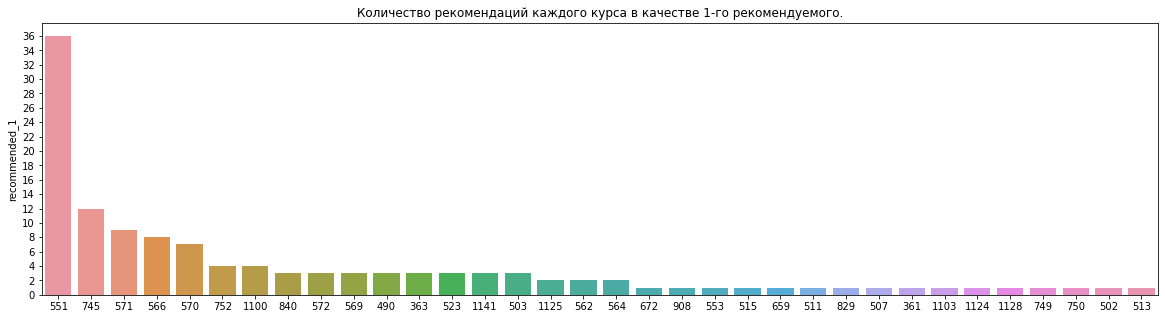

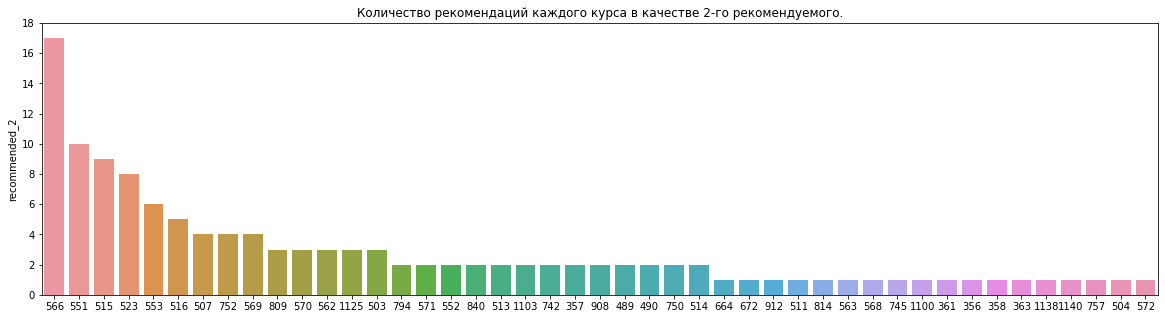

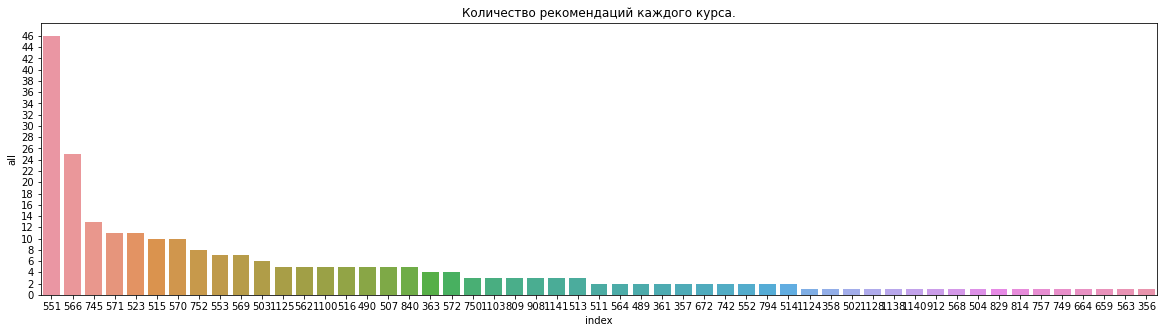

In [26]:
dataPlot = result['recommended_1'].value_counts()
plt.figure(figsize=(20,5))
ax = sns.barplot(x=dataPlot.index, y=dataPlot, order=dataPlot.index)
ax.set_title('Количество рекомендаций каждого курса в качестве 1-го рекомендуемого.')
_ = ax.set_yticks([i for i in range(0, max(dataPlot)+2, 2)])

dataPlot = result['recommended_2'].value_counts()
plt.figure(figsize=(20,5))
ax = sns.barplot(x=dataPlot.index, y=dataPlot, order=dataPlot.index)
ax.set_title('Количество рекомендаций каждого курса в качестве 2-го рекомендуемого.')
_ = ax.set_yticks([i for i in range(0, max(dataPlot)+2, 2)])

dataPlot = result['recommended_2'].value_counts().append(result['recommended_1'].value_counts())\
    .reset_index().groupby('index').sum().sort_values(0, ascending=False)\
    .rename(columns={0: 'all'})['all']
plt.figure(figsize=(20,5))
ax = sns.barplot(x=dataPlot.index, y=dataPlot, order=dataPlot.index, )
ax.set_title('Количество рекомендаций каждого курса.')
_ = ax.set_yticks([i for i in range(0, max(dataPlot)+2, 2)])

In [27]:
print('Медиана и среднее кол-во рекомендованных (соответственно):', dataPlot.median(), 'и', round(dataPlot.mean()))
print('Первые 5 курсов по популярности использования в качестве рекомендуемых:',\
      str(dataPlot.to_frame().reset_index().rename(columns={'index': 'resource_id'}).iloc[0:5]['resource_id'].to_list()))

Медиана и среднее кол-во рекомендованных (соответственно): 2.0 и 5
Первые 5 курсов по популярности использования в качестве рекомендуемых: [551, 566, 745, 571, 523]


<a id='Task1_end'></a>
### Результаты работы с задачей 1.
Были получены данные по продажам курсов, создана табличка по совместной покупке курсов каждым из пользователей, определены все возможные пары продаваемых совместно курсов, рассчитана популярность каждой пары. Были найдены самые продаваемые курсы. На основании полученных сведений был создан итоговый DataFrame в котором для каждого курса подобрано два рекомендуемых исходя из основного условия популярности пар совместно продаваемых курсов и дополнительного условия по самому продаваемому, если основное условие не сработало.

Немного фактов и статистики:
1. Всего курсов 126.
2. В среднем каждый курс участвует в рекомендациях в пяти других.
3. Первые 5 курсов по популярности использования в качестве рекомендуемых: [551, 566, 745, 571, 570]
4. В 17 случаях (13%) в качестве рекомендованных курсов предлагались на основании популярности продаж, а не на основании популярности совместных приобретений.

Рекомендации и дальнейшая работа:
1. Использовать полученные результаты непосредственно в работе с проведением A/B-тестирования.
2. Текущая работа проводилась на весьма скудном наборе данных. Рекомендуется дополнить данные названиями курсов, тематикой, данными по трендовым темам (популярности в Интернете), данными по пользователям и пр.
3. Рассмотреть возможность применения совместно с "пунктом 2" методов машинного обучения классификации и/или кластеризации.

Рассчитаем минимальный размер выборки необходимые для проведения А/Б тестирования при уровне достоверности 95% и статистической мощности 80%. Перед началом внедрения системы рекомендации конверсия купивших более одного курса 3,2%, ожидаем поднятие конверсии до 4%.

In [28]:
conv = 0.032
conv_new = 0.04
n = 16*conv*(1-conv)/(conv_new-conv)**2
print('Минимальный размер выборки для проведения А/Б-тестирования:', int(n))

Минимальный размер выборки для проведения А/Б-тестирования: 7744


<a id='Task2_start'></a>
## Задача 2. Анализ результатов A/B тестирования по внедрению рекомендаций по курсам.

По прошествии месяца после внедрения системы рекомендации нам прислали результаты A/B тестирования:
в тестовой группе из 8732 клиентов купили больше одного курса 293 клиента, в контрольной из 8847 клиентов - 347 купили.

Сформируем нулевую гипотезу H0: конверсия купивших более одного курса в тестовой и контрольной группе не изменилась.
Выборки достаточной большие, случайные и независимые. Размеры выборок больше минимально необходимого.
Протестируем нулевую гипотезу на уровне значимости в 5%.

In [29]:
n1 = 8732
n2 = 8847
p1 = 293/n1
p2 = 347/n2
print('Конверсия в покупку больше одного курса в тестовой группе пользователей', round(p1,4))
print('Конверсия в покупку больше одного курса в контрольнй группе пользователей', round(p2,4))

Конверсия в покупку больше одного курса в тестовой группе пользователей 0.0336
Конверсия в покупку больше одного курса в контрольнй группе пользователей 0.0392


In [30]:
from statsmodels.stats.proportion import proportions_ztest
count = [293, 347]
nobs = [n1, n2]
z_stat, p_value = proportions_ztest(count, nobs)
print('Сравнение двух пропорций номинативных переменных (купил/не купил) на \nосновании нормального распределения (z-статистика) \np-value = ',round(p_value,3))

Сравнение двух пропорций номинативных переменных (купил/не купил) на 
основании нормального распределения (z-статистика) 
p-value =  0.045


Нулевая гипотеза отвергается, различия в конверсии статистически значимы.

In [31]:
from scipy import stats
z_stat, p_value = stats.chisquare([347, n2], [293, n1])
print('Сравнение двух пропорций (наблюдаемые значения и ожидаемые значения) номинативных переменных (купил/не купил) \nпри помощи статистического теста ХИ-квадрат Пирсона \np-value = ',round(p_value,3))

Сравнение двух пропорций (наблюдаемые значения и ожидаемые значения) номинативных переменных (купил/не купил) 
при помощи статистического теста ХИ-квадрат Пирсона 
p-value =  0.001


Нулевая гипотеза отвергается, различия в конверсии статистически значимы.

<a id='Task2_end'></a>
### Выводы к Задаче 2. 
По результатам проведения А/Б тестирования и проверки гипотезы об изменении (увеличении) конверсии в покупку больше одного курса на статистическую значимость считаю целесобразными внедрения системы рекомендации курсов.